# Exploring the Iris dataset

This notebook explores the Iris dataset using visualization and **Principal Components Analysis (PCA)**, and compares **k-Means** and **Gaussian Mixture Model (GMM)** clustering using the **adjusted Rand score**.

<!-- 

this does make links when rendered to html, 
but when you click on one it opens in another tab in a distorted view...

## Contents

1. [Imports](#Imports)
1. [Get Data](#GetData)
1. [Visualize Data](#VisualizeData)
1. [Feature Scaling](#FeatureScaling)
1. [K-Means Clustering](#KMeansClustering)
1. [Principal Components Analysis (PCA)](#PCA)
1. [Gaussian Mixture Model (GMM)](#GMM)
1. [Comparing K-Means and GMM](#Comparing)
1. [Conclusion](#Conclusion)
-->

<a id='Imports'></a>

----------

## Imports

In [1]:
# import some libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# seaborn is a layer on top of matplotlib which has additional visualizations -
# just importing it changes the look of the standard matplotlib plots.
# the current version also shows some warnings which we'll disable.
import seaborn as sns
sns.set(style="white", color_codes=True)
import warnings
warnings.filterwarnings("ignore")

# show plots inline
%matplotlib inline

<a id='GetData'></a>

----

## Get Data

In [ ]:
# get data from kaggle and show some records
#data = pd.read_csv('../input/Iris.csv')
#data = data.drop('Id', axis=1) # get rid of the Id column - don't need it

In [14]:
# get data from sklearn and convert it to the form of the original csv from kaggle
from sklearn import datasets

iris = datasets.load_iris()

# convert to a pandas dataframe
data = pd.DataFrame(iris.data, columns=['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm'])
data['SpeciesId'] = iris.target

# convert numeric species id's to strings
speciesNames = {
    0: 'Setosa',
    1: 'Versicolour',
    2: 'Virginica'
}
data['Species'] = data['SpeciesId'].map(speciesNames)
data = data.drop('SpeciesId',1)

data.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
128,6.4,2.8,5.6,2.1,Virginica
99,5.7,2.8,4.1,1.3,Versicolour
90,5.5,2.6,4.4,1.2,Versicolour
69,5.6,2.5,3.9,1.1,Versicolour
78,6.0,2.9,4.5,1.5,Versicolour


In [6]:
# split data into features (X) and labels (y)
X = data.iloc[:,0:4]
y = data.iloc[:,-1]
print(X.sample(5))
print(y.sample(5))

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
11             4.8           3.4            1.6           0.2
48             5.3           3.7            1.5           0.2
144            6.7           3.3            5.7           2.5
71             6.1           2.8            4.0           1.3
67             5.8           2.7            4.1           1.0
52     Versicolour
44          Setosa
70     Versicolour
111      Virginica
101      Virginica
Name: Species, dtype: object


<a id='VisualizeData'></a>

----

## Visualize Data

For more visualizations see Ben Hamner's notebook - https://www.kaggle.com/benhamner/d/uciml/iris/python-data-visualizations - I borrowed a couple of things from there. 

In [7]:
# see how many samples we have of each species 
data["Species"].value_counts()

Setosa         50
Versicolour    50
Virginica      50
dtype: int64

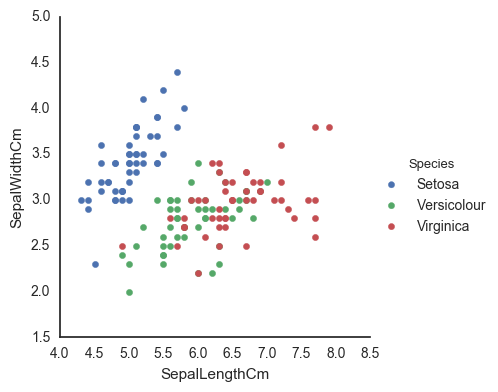

In [8]:
# use seaborn to make scatter plot showing species for each sample
sns.FacetGrid(data, hue="Species", size=4) \
   .map(plt.scatter, "SepalLengthCm", "SepalWidthCm") \
   .add_legend();

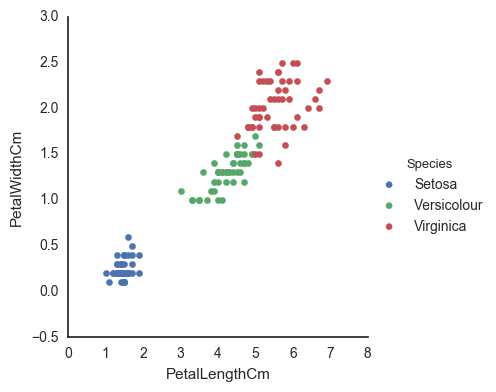

In [9]:
# do same for petals
sns.FacetGrid(data, hue="Species", size=4) \
   .map(plt.scatter, "PetalLengthCm", "PetalWidthCm") \
   .add_legend();

In [10]:
# note that the species are nearly linearly separable with petal size,
# but sepal sizes are more mixed.

# but a clustering algorithm might have a hard time realizing that there were
# three separate species, which we happen to know in advance - 
# usually if you're doing exploratory data analysis (EDA), you don't know this, 
# e.g. if you were looking for different groups of customers. 

# it might not matter too much though - e.g. the versicolor and virginica species
# seem to be very similar, so it might be just as well for your 
# purposes to lump them together.

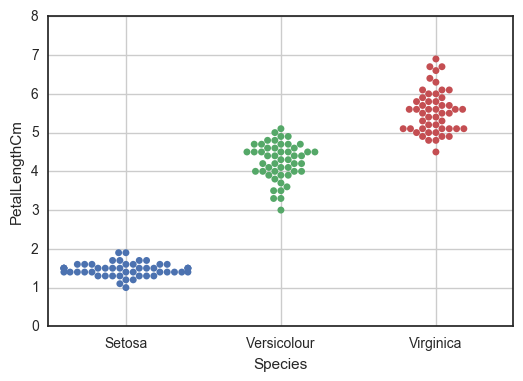

In [11]:
# show petal length distributions in a swarm plot - 
# just shows one dimension of the data, so not as useful as the previous plots
sns.swarmplot(x="Species", y="PetalLengthCm", data=data)
plt.grid()

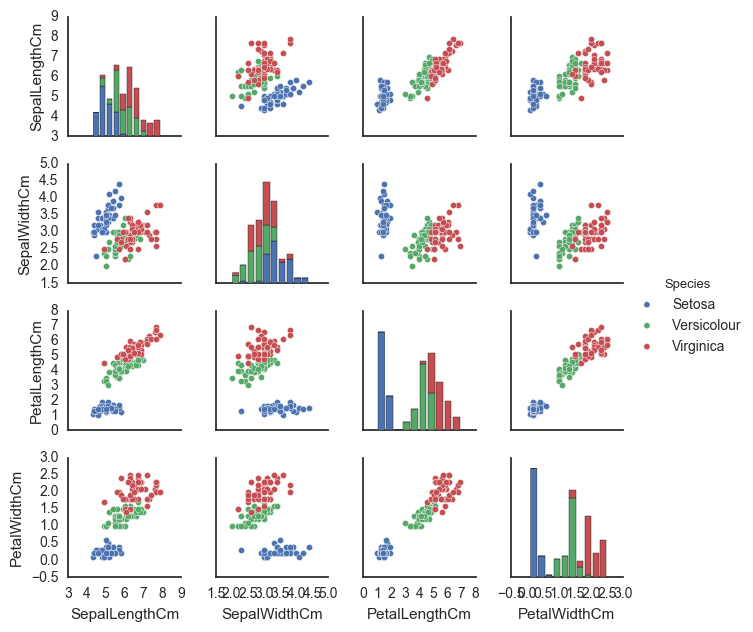

In [15]:
# make a scatter matrix showing each pair of features in the data.
# seaborn can show the species labels as different colors, but
# normally with EDA you wouldn't have that information. 
# note: the semicolon at the end just hides a line of text output.
sns.pairplot(data, hue="Species", diag_kind="hist", size=1.6);

In [13]:
# so again, this shows how similar versicolor and virginica are, at least with the given features.

# but there could be features that you didn't measure that would more clearly separate the species.

# it's the same for any unsupervised learning - you need to have the right features
# to separate the groups in the best way.

<a id='FeatureScaling'></a>

----

## Feature Scaling

In [16]:
# the data is unbalanced (eg sepallength ~4x petalwidth), so should do feature scaling,
# otherwise the larger features will dominate the others in clustering, etc.

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns = X.columns)

X_scaled.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
91,0.310998,-0.124958,0.478430,0.264699
72,0.553333,-1.281972,0.649027,0.396172
136,0.553333,0.800654,1.047087,1.579429
98,-0.900681,-1.281972,-0.431421,-0.129720
114,-0.052506,-0.587764,0.762759,1.579429


<a id='KMeansClustering'></a>

----

## K-Means Clustering

In [17]:
# try clustering on the 4d data and see if can reproduce the actual clusters.

# ie imagine we don't have the species labels on this data and wanted to
# divide the flowers into species. could set an arbitrary number of clusters
# and try dividing them up into similar clusters.

# we happen to know there are 3 species, so let's find 3 species and see
# if the predictions for each point matches the label in y.

from sklearn.cluster import KMeans

nclusters = 3 # this is the k in kmeans
seed = 0

km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X_scaled)

# predict the cluster for each data point
y_cluster_kmeans = km.predict(X_scaled)
y_cluster_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [18]:
# ordinarily, when you don't have the actual labels, you might use 
# silhouette analysis to determine a good number of clusters k to use. 

# i.e. you would just run that same code for different values of k and print the value for 
# the silhouette score. 

# let's see what that value is for the case we just did, k=3. 

> **Silhouette score** - a value near +1 indicates that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [19]:
from sklearn import metrics
score = metrics.silhouette_score(X_scaled, y_cluster_kmeans)
score

0.45897178670187183

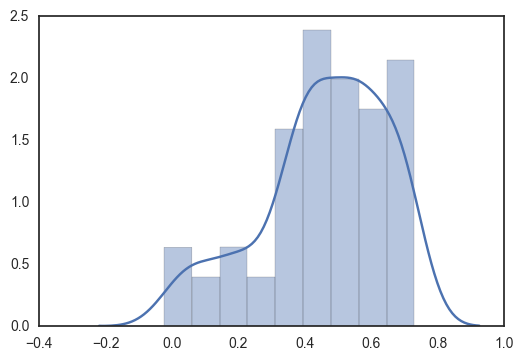

In [20]:
# note that this is the mean over all the samples - there might be some clusters 
# that are well separated and others that are closer together. 

# so let's look at the distribution of silhouette scores...

scores = metrics.silhouette_samples(X_scaled, y_cluster_kmeans)
sns.distplot(scores);

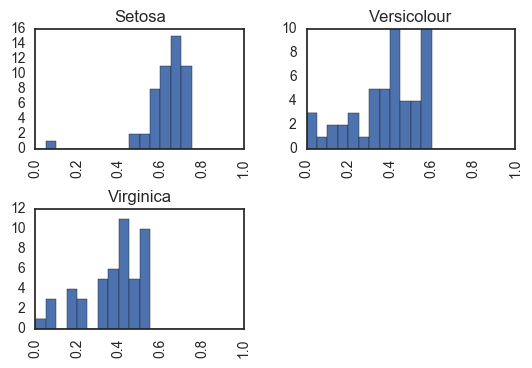

In [21]:
# can we add the species info to that plot?
# well, can plot them separately using pandas - 
df_scores = pd.DataFrame()
df_scores['SilhouetteScore'] = scores
df_scores['Species'] = data['Species']
df_scores.hist(by='Species', column='SilhouetteScore', range=(0,1.0), bins=20);

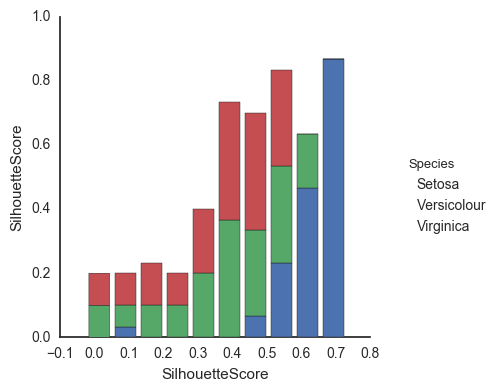

In [22]:
# so as expected, versicolor and virginica have lower silhouette scores than 
# the more separate setosas, because they are closer together.

# can we put them all on one histogram?
# yes, with a bit of a hack - it's not in seaborn yet - 
# see https://github.com/mwaskom/seaborn/issues/861
sns.pairplot(df_scores, hue="Species", size=4);

In [23]:
# so you can see that the blue species have higher silhouette scores
# (the legend doesn't show the colors though... so the pandas plot is more useful). 

# note that if we used the best mean silhouette score to try to find the best
# number of clusters k, we'd end up with 2 clusters, because the mean silhouette 
# score in that case would be largest, since the clusters would be better separated. 

# but, that's using k-means - gmm might give better results...

<a id='PCA'></a>

----

## Principal Component Analysis (PCA)

In [24]:
# so that was clustering on the orginal 4d data.

# if you have a lot of features it can be helpful to do some feature reduction
# to avoid the curse of dimensionality (i.e. needing exponentially more data
# to do accurate predictions as the number of features grows).

# you can do this with Principal Component Analysis (PCA), which remaps the data
# to a new (smaller) coordinate system which tries to account for the
# most information possible.

# you can *also* use PCA to visualize the data by reducing the 
# features to 2 dimensions and making a scatterplot. 
# it kind of mashes the data down into 2d, so can lose 
# information - but in this case it's just going from 4d to 2d, 
# so not losing too much info. 

# so let's just use it to visualize the data...

In [26]:
# mash the data down into 2 dimensions

from sklearn.decomposition import PCA

ndimensions = 2

pca = PCA(n_components=ndimensions) #, random_state=seed) # no random_state in sklearn 0.16?
pca.fit(X_scaled)
X_pca_array = pca.transform(X_scaled)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2']) # PC=principal component
X_pca.sample(5)

,PC1,PC2
84,0.221417,0.280848
64,-0.037258,0.432795
124,1.704241,-1.014148
51,0.732481,-0.598636
0,-2.264542,-0.505704


In [ ]:
# so that gives us new 2d coordinates for each data point.

# at this point, if you don't have labelled data,
# you can add the k-means cluster ids to this table and make a
# colored scatterplot. 

# we do actually have labels for the data points, but let's imagine
# we don't, and use the predicted labels to see what the predictions look like.

In [28]:
# first, convert species to an arbitrary number
y_id_array = pd.Categorical.from_array(data['Species']).codes

df_plot = X_pca.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['SpeciesId'] = y_id_array # also add actual labels so we can use it in later plots
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,SpeciesId
74,0.700473,0.063494,0,1
132,1.860371,0.184672,2,2
97,0.573883,0.153720,0,1
130,2.435497,-0.246654,2,2
114,1.464062,0.444148,0,2


In [58]:
# so now we can make a 2d scatterplot of the clusters
# first define a plot fn

def plotData(df, groupby):
    "make a scatterplot of the first two principal components of the data, colored by the groupby field"
    
    # make a figure with just one subplot.
    # you can specify multiple subplots in a figure, 
    # in which case ax would be an array of axes,
    # but in this case it'll just be a single axis object.
    fig, ax = plt.subplots(figsize = (7,7))

    # color map
    cmap = mpl.cm.get_cmap('brg')

    # we can use pandas to plot each cluster on the same graph.
    # see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
    for i, cluster in df.groupby(groupby):
        #print i, float(i)/(nclusters-1)
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(float(i)/(nclusters-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title("Principal Components Analysis (PCA) of Iris Dataset");

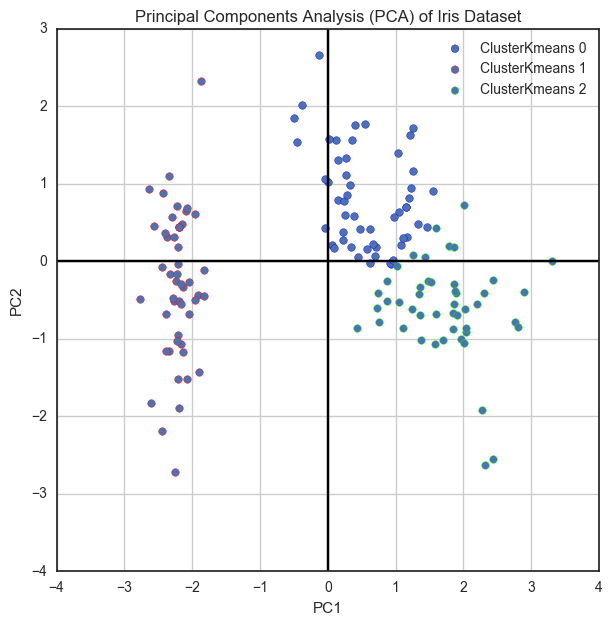

In [59]:
# plot the clusters each datapoint was assigned to
plotData(df_plot, 'ClusterKmeans')

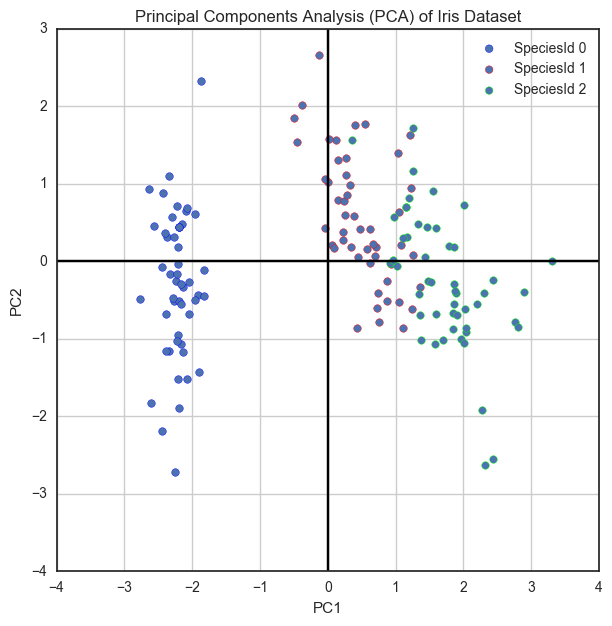

In [60]:
# so those are the *predicted* labels - what about the *actual* labels?
plotData(df_plot, 'SpeciesId')

In [61]:
# so the k-means clustering *did not* find the correct clusterings!

# q. so what do these dimensions mean?

# they're the principal components, which pick out the directions 
# of maximal variation in the original data.
# PC1 finds the most variation, PC2 the second-most. 
# the rest of the data is basically thrown away when the data is reduced down to 2d.

# q. if these principal components represent some latent (hidden) features, what would those be? 

# maybe size (area) of the petals and sepals? 

<a id='GMM'></a>

----

## Gaussian Mixture Model (GMM) Clustering

In [63]:
# now let's try GMM clustering, which tries to fit normally-distributed clusters, 
# and might be the case when measuring things like petal and sepal sizes...

#from sklearn.mixture import GaussianMixture # v0.18
from sklearn.mixture import GMM

#gmm = GaussianMixture(n_components=nclusters)
gmm = GMM(n_components=nclusters)
gmm.fit(X_scaled)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_scaled)
y_cluster_gmm

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

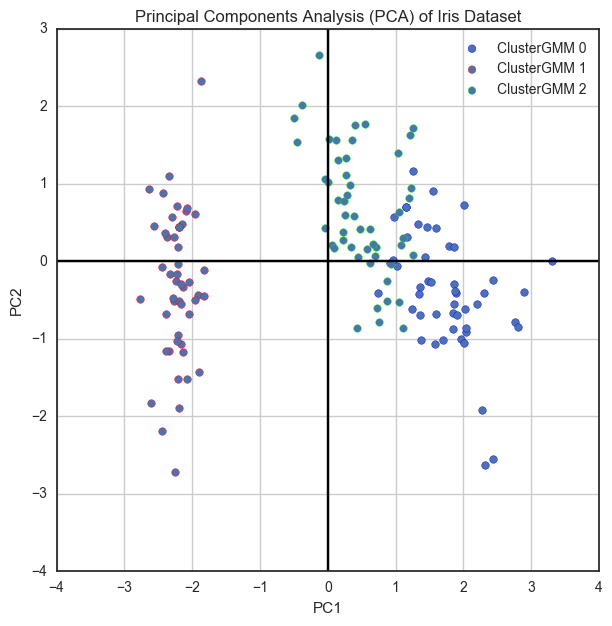

In [64]:
# add the GMM clusters to our data table and plot them
df_plot['ClusterGMM'] = y_cluster_gmm
plotData(df_plot, 'ClusterGMM')

In [65]:
# the GMM did much better at finding the actual species clusters! how did it do that? 

# GMM tries to fit normally distributed clusters, which is probably the case with this data,
# so it fit it better. k-means is biased towards spherically distributed clusters.

<a id='Comparing'></a>

----

## Comparing k-Means and GMM clustering

In [66]:
# q. so how much better did the GMM do versus the K-means clustering? ie quantify it...

# you can't just compare the SpeciesId with the cluster numbers, because they are
# both arbitrarily assigned integers.

# but you can use the *adjusted Rand score* to quantify the goodness of the clustering,
# as compared with SpeciesId (the true labels).

# e.g. this will give a perfect score of 1.0, even though the labels are reversed - 
# adjusted_rand_score([0,0,1,1], [1,1,0,0]) # => 1.0

# see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

from sklearn.metrics.cluster import adjusted_rand_score

# first let's see how the k-means clustering did - 
score = adjusted_rand_score(y, y_cluster_kmeans)
score

0.6201351808870379

In [67]:
# now the GMM clustering - 
score = adjusted_rand_score(y, y_cluster_gmm)
score

0.8680377279943841

In [68]:
# so the GMM clustering matched the true labels more closely than the Kmeans,
# as expected from the plots.

<a id='Conclusion'></a>

----

## Conclusion

**Principal Component Analysis (PCA)** is useful for visualizing high-dimensional datasets, as it can compress it down to 2 dimensions. It's *also* useful for reducing the dimensionality of high-dimensional datasets, which require exponentially more data as the number of dimensions increase, but we didn't need to do that in this case because the dataset was rather small. 

**k-Means Clustering** is biased towards spherical distributions of clusters, and makes hard assignments to clusters, but is very fast (linear in number of features and data points). 

**Gaussian Mixture Model (GMM) Clustering** handles ellipsoidal distributions, and makes 'soft' assignments to clusters, but is much slower than k-means for large datasets.

For this dataset, which was measuring what were probably normally distributed features, the GMM clustering worked better at finding the actual species labels, as measured by the **adjusted Rand score**. 
